In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf

11493376/11490434 [==============================] - 0s 0us/step


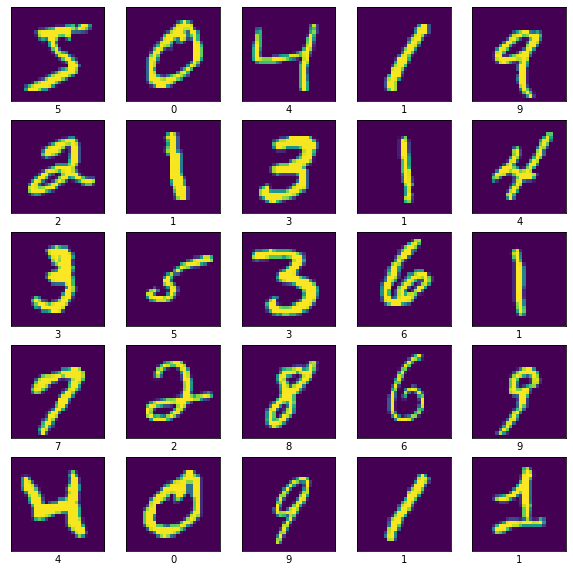

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i])
    plt.xlabel(y_train[i])
plt.show()

x_train = x_train / 255.0
x_test = x_test / 255.0
y_train = tf.one_hot(y_train, 10)
y_test = tf.one_hot(y_test, 10)
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_data = tf.data.Dataset.from_tensor_slices((x_test, y_test))

In [3]:
class CustomDense1(tf.keras.layers.Layer):
    def __init__(self, input_dim, units, activation):
        super(CustomDense1, self).__init__()
        self.w = tf.Variable(initial_value=tf.random.normal(shape=(input_dim, units), mean=0., stddev=1.),
                             trainable=True)
        self.b = tf.Variable(initial_value=tf.zeros(shape=(units,)),
                             trainable=True)
        self.activation = tf.keras.activations.get(activation)

    def call(self, inputs):
        return self.activation(tf.linalg.matmul(inputs, self.w) + self.b)


custom_dense1 = CustomDense1(input_dim=2, units=1, activation='relu')
assert custom_dense1.weights == [custom_dense1.w, custom_dense1.b]
assert custom_dense1.trainable_weights == [custom_dense1.w, custom_dense1.b]
assert custom_dense1.non_trainable_weights == []


class CustomDense2(tf.keras.layers.Layer):
    def __init__(self, input_dim, units, activation):
        super(CustomDense2, self).__init__()
        self.input_dim = input_dim
        self.units = units
        self.activation = tf.keras.activations.get(activation)

    def build(self):
        self.w = self.add_weight(shape=(self.input_dim, self.units), initializer='random_normal',
                                 trainable=True)
        self.b = self.add_weight(shape=(self.units,), initializer='random_normal',
                                 trainable=True)

    def call(self, inputs):
        return self.activation(tf.linalg.matmul(inputs, self.w) + self.b)


class CustomDropout(tf.keras.layers.Layer):
    def __init__(self, rate):
        super(CustomDropout, self).__init__()
        self.rate = rate

    def call(self, inputs, training=None):
        if training:
            return tf.nn.dropout(inputs, rate=self.rate)
        return inputs


class CustomCombinationLayer(tf.keras.layers.Layer):
    def __init__(self, input_dim, units, activation):
        super(CustomCombinationLayer, self).__init__()
        self.custom_dense1 = CustomDense1(input_dim, units, activation)
        self.custom_dropout = CustomDropout(0.5)

    def call(self, inputs, training=None):
        a = self.custom_dense1(inputs)
        return self.custom_dropout(a, training=training)

In [4]:
class CustomModel(tf.keras.models.Model):
    def __init__(self):
        super(CustomModel, self).__init__()
        self.hidden_layer1 = CustomCombinationLayer(input_dim=784, units=16, activation='relu')
        self.hidden_layer2 = CustomCombinationLayer(input_dim=16, units=16, activation='relu')
        self.hidden_layer3 = CustomCombinationLayer(input_dim=16, units=16, activation='relu')
        self.output_layer = CustomCombinationLayer(input_dim=16, units=10, activation='softmax')

    def call(self, inputs, training=True):
        hidden1 = self.hidden_layer1(inputs, training=training)
        hidden2 = self.hidden_layer2(hidden1, training=training)
        hidden3 = self.hidden_layer3(hidden2, training=training)
        return self.output_layer(hidden3, training=training)


model = CustomModel()

In [5]:
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.CategoricalCrossentropy()
accuracy = tf.keras.metrics.CategoricalAccuracy()

In [6]:
@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        logits = model(x, training=True)
        loss_value = loss(y, logits)
        gradients = tape.gradient(loss_value, model.trainable_weights)
        optimizer.apply_gradients(zip(gradients, model.trainable_weights))
        accuracy.update_state(y, logits)

    return loss_value


def test_step(x, y):
    accuracy.reset_states()
    logits = model(x, training=False)
    accuracy.update_state(y, logits)


for epoch in range(5):
    print('%d번째 epoch' % (epoch + 1))
    for index, (x, y) in enumerate(train_data):
        loss_value = train_step(x, y)
        if index % 100 == 0:
            print('%d 단계 / loss_value: %f / accuracy: %f' % (index, float(loss_value), float(accuracy.result())))
    for step, (x, y) in enumerate(test_data):
        test_step(x, y)
        print('test accuracy: %f' % (float(accuracy.result())))

1번째 epoch


ValueError: in user code:

    <ipython-input-6-b2c540bf7fc7>:4 train_step  *
        logits = model(x, training=True)
    <ipython-input-4-c697150d4444>:10 call  *
        hidden1 = self.hidden_layer1(inputs, training=training)
    <ipython-input-3-75c173148f0a>:58 call  *
        a = self.custom_dense1(inputs)
    <ipython-input-3-75c173148f0a>:11 call  *
        return self.activation(tf.linalg.matmul(inputs, self.w) + self.b)
    C:\Users\82106\anaconda3\lib\site-packages\tensorflow\python\util\dispatch.py:206 wrapper  **
        return target(*args, **kwargs)
    C:\Users\82106\anaconda3\lib\site-packages\tensorflow\python\ops\math_ops.py:3490 matmul
        a, b, transpose_a=transpose_a, transpose_b=transpose_b, name=name)
    C:\Users\82106\anaconda3\lib\site-packages\tensorflow\python\ops\gen_math_ops.py:5717 mat_mul
        name=name)
    C:\Users\82106\anaconda3\lib\site-packages\tensorflow\python\framework\op_def_library.py:750 _apply_op_helper
        attrs=attr_protos, op_def=op_def)
    C:\Users\82106\anaconda3\lib\site-packages\tensorflow\python\framework\func_graph.py:601 _create_op_internal
        compute_device)
    C:\Users\82106\anaconda3\lib\site-packages\tensorflow\python\framework\ops.py:3565 _create_op_internal
        op_def=op_def)
    C:\Users\82106\anaconda3\lib\site-packages\tensorflow\python\framework\ops.py:2042 __init__
        control_input_ops, op_def)
    C:\Users\82106\anaconda3\lib\site-packages\tensorflow\python\framework\ops.py:1883 _create_c_op
        raise ValueError(str(e))

    ValueError: Dimensions must be equal, but are 28 and 784 for '{{node custom_model/custom_combination_layer/custom_dense1_1/MatMul}} = MatMul[T=DT_FLOAT, transpose_a=false, transpose_b=false](custom_model/Cast, custom_model/custom_combination_layer/custom_dense1_1/MatMul/ReadVariableOp)' with input shapes: [28,28], [784,16].
